In [42]:
import numpy as np
from datetime import datetime, timezone
from random import randint
from time import sleep
import itertools
import pandas as pd
from random import shuffle
import pandas as pd
import subprocess
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import numpy as np

Initially there is no data

In [43]:
result = subprocess.check_output(["node", "contest.js", "status"])
pd.read_csv(pd.compat.StringIO(result.decode('UTF-8')))

Empty DataFrame
Columns: [Entry,  "Round",  "Address"]
Index: []

Here is a simulation. Let's say there are 4 oracles. Each oracle would periodically send the time in their clock

In [44]:
def time_api_mock():
    return "%d" % datetime.now(timezone.utc).timestamp()

In [45]:
oracles = ['QcLnMVBAU6HLtddv2HwufpzBbgrnno9Tbj', 'Qco3FvfV8FdWVoCb4DGnGDhHxiUAYjYuqK', 
           'QfSiJx6Uci9NjPaGY8dfx1SykTL3FbB6KX', 'QTkn2k3gGDjTvHzCsB4tNPpgP9MbGSm7Td']

for i in range(10):
    if i % 4 == 0:
        shuffle(oracles)
    subprocess.call(["node", "contest.js", "submit", oracles[i%4], time_api_mock()])

In [46]:
result = subprocess.check_output(["node", "contest.js", "status"])
df = pd.read_csv(pd.compat.StringIO(result.decode('UTF-8')), quotechar='"',skipinitialspace = True)
df

Entry  Round                                   Address
0  1537064182      1  aca1f5d083eadbbe5ef1e25c5d8909cbda42e1d7
1  1537064202      1  b19937706fd4bb887da45db2507bf819ed75105a
2  1537064222      1  cea97532c40601d7aec34cfd11f0096e4be66556
3  1537064242      2  4e728a9e39b59215d5e5a474503daf5b29f29651
4  1537064262      2  cea97532c40601d7aec34cfd11f0096e4be66556
5  1537064282      2  b19937706fd4bb887da45db2507bf819ed75105a
6  1537064302      3  aca1f5d083eadbbe5ef1e25c5d8909cbda42e1d7
7  1537064322      3  4e728a9e39b59215d5e5a474503daf5b29f29651
8  1537064362      3  b19937706fd4bb887da45db2507bf819ed75105a

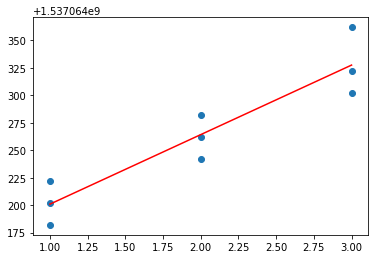

In [47]:
%matplotlib inline
md = smf.ols('Entry ~ Round', df)
md_fit = md.fit(reml=True)

intercept = md_fit.params[0]
slope = md_fit.params[1]

fig, ax = plt.subplots(figsize=(6,4))
ax = plt.scatter(df.Round, df.Entry)
xstart, xstop = min(df.Round), max(df.Round)
ystart, ystop = xstart * slope + intercept, xstop * slope + intercept
plt.plot([xstart, xstop], [ystart, ystop], 'r-')

In [48]:
def remove_outliers(df):
    md = smf.ols('Entry ~ Round', df)
    md_fit = md.fit(reml=True)

    intercept = md_fit.params[0]
    slope = md_fit.params[1]
    
    df['actual'] = df.Round * slope + intercept
    df['valid'] = abs(df.actual - df.Entry) <= 25.0
    
    g = df.groupby(['Round'])
    groups = []
    for k,n in g:
        valids = n[n.valid].reset_index()
        valids["score"] = 1 / valids.shape[0]
        groups.append(valids)

    result = pd.concat(groups)
    return result.groupby(['Address'])['score'].sum().to_dict()

In [49]:
final_evaluation = remove_outliers(df)
template = "Run:\n solar deploy --force Evaluation.sol '[%s]'"
print(template % str(list(final_evaluation.keys())).replace("'", '"'))

Run:
 solar deploy --force Evaluation.sol '[["4e728a9e39b59215d5e5a474503daf5b29f29651", "aca1f5d083eadbbe5ef1e25c5d8909cbda42e1d7", "b19937706fd4bb887da45db2507bf819ed75105a", "cea97532c40601d7aec34cfd11f0096e4be66556"]]'


In [50]:
df

Entry  Round                                   Address        actual  \
0  1537064182      1  aca1f5d083eadbbe5ef1e25c5d8909cbda42e1d7  1.537064e+09   
1  1537064202      1  b19937706fd4bb887da45db2507bf819ed75105a  1.537064e+09   
2  1537064222      1  cea97532c40601d7aec34cfd11f0096e4be66556  1.537064e+09   
3  1537064242      2  4e728a9e39b59215d5e5a474503daf5b29f29651  1.537064e+09   
4  1537064262      2  cea97532c40601d7aec34cfd11f0096e4be66556  1.537064e+09   
5  1537064282      2  b19937706fd4bb887da45db2507bf819ed75105a  1.537064e+09   
6  1537064302      3  aca1f5d083eadbbe5ef1e25c5d8909cbda42e1d7  1.537064e+09   
7  1537064322      3  4e728a9e39b59215d5e5a474503daf5b29f29651  1.537064e+09   
8  1537064362      3  b19937706fd4bb887da45db2507bf819ed75105a  1.537064e+09   

   valid  
0   True  
1   True  
2   True  
3   True  
4   True  
5   True  
6  False  
7   True  
8  False

In [51]:
final_evaluation

{'4e728a9e39b59215d5e5a474503daf5b29f29651': 1.3333333333333333,
 'aca1f5d083eadbbe5ef1e25c5d8909cbda42e1d7': 0.3333333333333333,
 'b19937706fd4bb887da45db2507bf819ed75105a': 0.6666666666666666,
 'cea97532c40601d7aec34cfd11f0096e4be66556': 0.6666666666666666}

In [52]:
for i in range(len(final_evaluation.keys()) * 3):
    target = subprocess.check_output(["node", "evaluate.js", "reviewee"]).decode("utf-8").strip()
    subprocess.call(["node", "evaluate.js", "submit", oracles[i%4], "%d" % (final_evaluation[target] * 100)])

In [53]:
result = subprocess.check_output(["node", "evaluate.js", "status"])
pd.read_csv(pd.compat.StringIO(result.decode('UTF-8')), quotechar='"',skipinitialspace = True)

Reviewee  Score
0  4e728a9e39b59215d5e5a474503daf5b29f29651    133
1  aca1f5d083eadbbe5ef1e25c5d8909cbda42e1d7     33
2  b19937706fd4bb887da45db2507bf819ed75105a     66
3  cea97532c40601d7aec34cfd11f0096e4be66556     66